# Applied Data Science Captstone Project

First things first, import all required libraries:

In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import json

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

!pip install lxml
import lxml

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

print('Libraries imported.')

     |████████████████████████████████| 112kB 7.0MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 6.3MB/s eta 0:00:01�███████                       | 1.6MB 6.3MB/s eta 0:00:01
Libraries imported.


Get all the neighborhoods of Toronto:

In [4]:
# Define the wikipedia URL
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Send a GET request to the wikipedia site
wiki_data = requests.get(wiki_url).text

# Get the first dataframe in the list, since it is the one of interest
wiki_contents = pd.read_html(wiki_data)[0]

# Drop all postal codes where a borough is not assigned and reassign column names
print("Number of postal codes imported: " + str(wiki_contents.shape[0]))
wiki_contents = wiki_contents[wiki_contents['Borough'] != 'Not assigned']
wiki_contents.columns = ['PostalCode', 'Borough', 'Neighborhood']
print("Number of postal codes with boroughs: " + str(wiki_contents.shape[0]))
wiki_contents.head()

Number of postal codes imported: 180
Number of postal codes with boroughs: 103


,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now associate the respective postal codes with longitude and latitude coordinates:

In [5]:
# Create blank dataframe with columns
postalCodes = pd.DataFrame(columns = ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude'])

# Get data from provided csv file (geocoder wasn't working...)
latlng = pd.read_csv('Geospatial_Coordinates.csv')

# Iterate through all rows in the dataframe, getting the coordinates of each postal code
for index, row in wiki_contents.iterrows():
    
    # Get the row of the provided dataset matching the postal code
    coords = latlng[latlng['Postal Code'] == row['PostalCode']]
    
    # Append the results to the new dataframe
    postalCodes = postalCodes.append({'PostalCode': row['PostalCode'],
                                      'Borough': row['Borough'],
                                      'Neighborhood': row['Neighborhood'],
                                      'Latitude': coords.iloc[0]['Latitude'],
                                      'Longitude': coords.iloc[0]['Longitude']}, ignore_index=True)
postalCodes.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Do this same process for New York, however this dataset comes from a CSV files instead of a wikipedia page:

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Define a function to get venues nearby to a set of coordinates:

In [8]:
# Function defined in previous labs
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function defines above to get all the venues for each neighborhood in Toronto:

In [9]:
# Foursquare credentials
CLIENT_ID = 'ESJYUQSHS5XBNCATWTRVHGUQUGZLDONBLGXH1TNWAMKIACBT'
CLIENT_SECRET = 'WJC3UPEAYDQRUFCKL0WEQMP5R52QCCOOBZDDW2RJ4U30EUB1'
VERSION = '20180605'
LIMIT = 100

# Get center of Toronto coordinates to center map
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Initialize Map
map_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)

# Send all neighborhoods to get nearby venues using provided function
toronto_venues = getNearbyVenues(names=postalCodes['Neighborhood'],
                                   latitudes=postalCodes['Latitude'],
                                   longitudes=postalCodes['Longitude']
                                  )

In [10]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Do the same thing for New York:

In [11]:
# Get center of Toronto coordinates to center map
address = 'New York, NY'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Initialize Map
map_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)

# Send all neighborhoods to get nearby venues using provided function
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [12]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Label each neighborhood with the city it's in, then merge the two datasets:

In [13]:
toronto_venues["City"] = "Toronto"
newyork_venues["City"] = "New York"
all_venues = pd.concat([toronto_venues, newyork_venues])
all_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,Toronto
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant,Toronto
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,Toronto
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,Toronto
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,Toronto


Clean up the data and prepare it for clustering:

In [116]:
# Data cleaning = removal of categorical variables and grouping
onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Neighborhood'] = all_venues['Neighborhood'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
grouped = onehot.groupby('Neighborhood').mean().reset_index()

# Generate Dataframe with top 10 venues in each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

Add the pricing data (commented out for when not in use):

In [117]:
#nyc_price_url = "https://www.renthop.com/average-rent-in/new-york-city-ny"
#nyc_price_contents = requests.get(nyc_price_url).text
#nyc_prices = pd.read_html(nyc_price_contents)[1].dropna()
#nyc_prices = nyc_prices[["Neighborhood", "2BR"]]

#toronto_prices = pd.read_csv("Toronto Rent.csv")
#toronto_prices.columns = ["Neighborhood", "2BR"]
#nyc_prices = pd.concat([nyc_prices, toronto_prices]).dropna()

#nyc_prices[nyc_prices.columns[1:]] = nyc_prices[nyc_prices.columns[1:]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(np.int64)
#grouped = grouped.join(nyc_prices[['Neighborhood', '2BR']].set_index('Neighborhood'), on='Neighborhood')
#grouped_clustering_all = grouped.dropna()
grouped_clustering = grouped.drop('Neighborhood', 1)

Run the gather data through a k-Mean clustering algorithm:

In [119]:
# Run k-Means clustering on the location data, clustering like neightborhoods
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
# grouped_clustering_all["Cluster Labels"] = kmeans.labels_
neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_) #join(grouped_clustering_all[["Neighborhood", "Cluster Labels"]].set_index("Neighborhood"), on="Neighborhood")

postalCodes["City"] = "Toronto"
neighborhoods["City"] = "New York"
all_postals = pd.concat([postalCodes, neighborhoods])

merged = pd.concat([postalCodes, neighborhoods])

In [120]:
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
merged = merged[merged['Cluster Labels'].notna()]
merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,Toronto,2.0,Food & Drink Shop,Park,Fast Food Restaurant,Women's Store,Factory,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,Toronto,0.0,Hockey Arena,Pizza Place,Portuguese Restaurant,Financial or Legal Service,Coffee Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto,0.0,Coffee Shop,Pub,Café,Park,Bakery,Theater,Breakfast Spot,Bank,Beer Store,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto,0.0,Clothing Store,Accessories Store,Furniture / Home Store,Vietnamese Restaurant,Gift Shop,Boutique,Coffee Shop,Event Space,Event Service,Ethiopian Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto,0.0,Coffee Shop,Yoga Studio,Smoothie Shop,Bank,Bar,Beer Bar,Sushi Restaurant,Mexican Restaurant,Fried Chicken Joint,Portuguese Restaurant


Generate maps for each city:

In [122]:
# Get center of Toronto coordinates to center map
address = 'New York, NY'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create Map functions from other labs
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels'].astype('int32')):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [128]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create Map functions from other labs
map_clusters = folium.Map(width=500, height=500, location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels'].astype('int32')):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Generate a plot showing the clusters with all their prices:

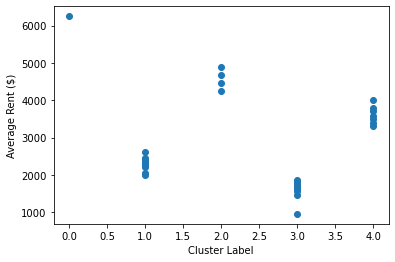

In [127]:
import matplotlib.pyplot as plt
plt.scatter(grouped_clustering_all["Cluster Labels"].astype('int'), grouped_clustering_all["2BR"])
plt.xlabel("Cluster Label")
plt.ylabel("Average Rent ($)")
plt.show()